# HAI Security Dataset Preprocessing

This notebook focuses on preprocessing the HIL-based Augmented ICS (HAI) Security Dataset. The dataset contains data collected from a realistic industrial control system (ICS) testbed augmented with a hardware-in-the-loop (HIL) simulator.

We'll start with the HAI-20.07 version and implement efficient preprocessing techniques to handle the large volume of data, optimizing for GPU processing (A100).

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import time
from datetime import datetime
import cudf  # GPU-accelerated DataFrame library
import cupy as cp  # GPU-accelerated NumPy-like library
import dask.dataframe as dd  # For parallel computing with DataFrames
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib  # For saving preprocessing objects
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Dataset Overview

First, let's explore the available dataset versions and their structure.

In [10]:
# List all available dataset versions
dataset_path = '../hai-security-dataset/'
dataset_versions = [os.path.basename(version) for version in glob.glob(f'{dataset_path}hai-*')]
dataset_versions.extend([os.path.basename(version) for version in glob.glob(f'{dataset_path}haiend-*')])
print(f"Available dataset versions: {dataset_versions}")

Available dataset versions: ['hai-23.05', 'hai-22.04', 'hai-21.03', 'hai-20.07', 'hai-security-dataset.zip', 'haiend-23.05']


## 2. Exploring HAI-20.07 Dataset

Let's start by exploring the HAI-20.07 dataset structure.

In [11]:
# List all files in HAI-20.07
hai_20_07_path = f'{dataset_path}hai-20.07/'
hai_20_07_files = [os.path.basename(file) for file in glob.glob(f'{hai_20_07_path}*.csv')]
print(f"Files in HAI-20.07: {hai_20_07_files}")

Files in HAI-20.07: ['train2.csv', 'train1.csv', 'test2.csv', 'test1.csv']


### 2.1 Efficient Data Loading

For HAI-20.07, we need to handle the semicolon-separated CSV files efficiently. We'll use Dask for parallel processing and then convert to cuDF for GPU acceleration.

In [14]:
def load_hai_20_07_file(file_path, sample_rows=None):
    """
    Load HAI-20.07 CSV file efficiently using Dask and cuDF.
    
    Args:
        file_path: Path to the CSV file
        sample_rows: Number of rows to sample (None for all rows)
        
    Returns:
        cudf.DataFrame: GPU-accelerated DataFrame
    """
    start_time = time.time()
    
    # First, use pandas to read a few rows to get column names and dtypes
    sample_df = pd.read_csv(file_path, sep=';', nrows=5)
    
    # Create a dictionary of dtypes to optimize memory usage
    dtypes = {}
    for col in sample_df.columns:
        if col == 'time':
            dtypes[col] = 'object'  # Keep timestamp as object initially
        elif 'attack' in col.lower():
            dtypes[col] = 'int8'  # Binary labels can be stored as int8
        elif sample_df[col].dtype == 'float64':
            # Keep as float32, don't try to convert floats to int
            dtypes[col] = 'float32'  # Reduce precision to save memory
        elif sample_df[col].dtype == 'int64':
            # Only convert integers to int32
            dtypes[col] = 'int32'  # Reduce precision to save memory
    
    # Use Dask to read the file in parallel chunks
    try:
        if sample_rows:
            # For sampling, use pandas directly
            df = pd.read_csv(file_path, sep=';', dtype=dtypes, nrows=sample_rows)
        else:
            # For full file, use Dask
            dask_df = dd.read_csv(file_path, sep=';', dtype=dtypes, blocksize="64MB")
            df = dask_df.compute()
    except ValueError as e:
        # If there's a dtype conversion error, try again without specifying dtypes
        print(f"Warning: Error with dtype conversion: {e}")
        print("Attempting to load without dtype specifications...")
        if sample_rows:
            df = pd.read_csv(file_path, sep=';', nrows=sample_rows)
        else:
            dask_df = dd.read_csv(file_path, sep=';', blocksize="64MB")
            df = dask_df.compute()
    
    # Convert to cuDF for GPU acceleration
    try:
        gpu_df = cudf.DataFrame.from_pandas(df)
        print(f"Data loaded and converted to GPU DataFrame in {time.time() - start_time:.2f} seconds")
        return gpu_df
    except Exception as e:
        print(f"Warning: Could not convert to GPU DataFrame: {e}")
        print(f"Data loaded in pandas DataFrame in {time.time() - start_time:.2f} seconds")
        return df

In [15]:
# Load a sample of the first training file to explore its structure
train1_path = f'{hai_20_07_path}train1.csv'
train1_sample = load_hai_20_07_file(train1_path, sample_rows=10000)

# Display basic information
print(f"Shape of train1.csv sample: {train1_sample.shape}")
print("\nFirst 5 rows:")
display(train1_sample.head())

Attempting to load without dtype specifications...
Data loaded and converted to GPU DataFrame in 0.38 seconds
Shape of train1.csv sample: (10000, 64)

First 5 rows:


,time,P1_B2004,P1_B2016,P1_B3004,P1_B3005,P1_B4002,P1_B4005,P1_B400B,P1_B4022,P1_FCV01D,...,P4_ST_FD,P4_ST_LD,P4_ST_PO,P4_ST_PS,P4_ST_PT01,P4_ST_TT01,attack,attack_P1,attack_P2,attack_P3
0,2019-09-11 20:00:00,0.0983,1.0702,399.2321,1110.3986,32,0.0,28.9981,35.7395,0.0,...,-0.0004,330.6568,328.9388,50.9871,9973.0,27629.0,0,0,0,0
1,2019-09-11 20:00:01,0.0983,1.0699,399.2321,1110.3986,32,0.0,29.9914,35.7388,0.0,...,-0.0012,330.2228,329.3728,50.9871,9973.0,27629.0,0,0,0,0
2,2019-09-11 20:00:02,0.0983,1.0703,399.2321,1110.3986,32,0.0,27.0122,35.7399,0.0,...,0.0018,332.0493,329.7526,50.9871,9973.0,27629.0,0,0,0,0
3,2019-09-11 20:00:03,0.0983,1.0719,399.2321,1110.3986,32,0.0,32.9705,35.7452,0.0,...,0.0033,331.5249,331.0547,50.9871,9973.0,27629.0,0,0,0,0
4,2019-09-11 20:00:04,0.0983,1.0710,399.2321,1110.3986,32,0.0,30.9843,35.7422,0.0,...,0.0015,333.1706,331.1631,50.9871,9973.0,27629.0,0,0,0,0


In [16]:
# Check column names and data types
print(f"Number of columns: {len(train1_sample.columns)}")
print("\nColumn names:")
print(train1_sample.columns.tolist())

# Check data types
print("\nData types:")
for col, dtype in zip(train1_sample.dtypes.index, train1_sample.dtypes):
    print(f"{col}: {dtype}")

Number of columns: 64

Column names:
['time', 'P1_B2004', 'P1_B2016', 'P1_B3004', 'P1_B3005', 'P1_B4002', 'P1_B4005', 'P1_B400B', 'P1_B4022', 'P1_FCV01D', 'P1_FCV01Z', 'P1_FCV02D', 'P1_FCV02Z', 'P1_FCV03D', 'P1_FCV03Z', 'P1_FT01', 'P1_FT01Z', 'P1_FT02', 'P1_FT02Z', 'P1_FT03', 'P1_FT03Z', 'P1_LCV01D', 'P1_LCV01Z', 'P1_LIT01', 'P1_PCV01D', 'P1_PCV01Z', 'P1_PCV02D', 'P1_PCV02Z', 'P1_PIT01', 'P1_PIT02', 'P1_TIT01', 'P1_TIT02', 'P2_24Vdc', 'P2_Auto', 'P2_Emgy', 'P2_On', 'P2_SD01', 'P2_SIT01', 'P2_TripEx', 'P2_VT01e', 'P2_VXT02', 'P2_VXT03', 'P2_VYT02', 'P2_VYT03', 'P3_LCP01D', 'P3_LCV01D', 'P3_LH', 'P3_LL', 'P3_LT01', 'P4_HT_FD', 'P4_HT_LD', 'P4_HT_PO', 'P4_HT_PS', 'P4_LD', 'P4_ST_FD', 'P4_ST_LD', 'P4_ST_PO', 'P4_ST_PS', 'P4_ST_PT01', 'P4_ST_TT01', 'attack', 'attack_P1', 'attack_P2', 'attack_P3']

Data types:
time: object
P1_B2004: float64
P1_B2016: float64
P1_B3004: float64
P1_B3005: float64
P1_B4002: int64
P1_B4005: float64
P1_B400B: float64
P1_B4022: float64
P1_FCV01D: float64
P1_FCV01Z:

### 2.2 Timestamp Conversion

Convert the timestamp column to datetime format for time-series analysis.

In [17]:
def convert_timestamp(df, timestamp_col='time'):
    """
    Convert timestamp column to datetime format.
    
    Args:
        df: DataFrame (pandas or cuDF)
        timestamp_col: Name of the timestamp column
        
    Returns:
        DataFrame with converted timestamp
    """
    if isinstance(df, cudf.DataFrame):
        # For cuDF DataFrame
        if timestamp_col in df.columns:
            df[timestamp_col] = df[timestamp_col].astype('datetime64[ns]')
    else:
        # For pandas DataFrame
        if timestamp_col in df.columns:
            df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    
    return df

In [18]:
# Convert timestamp
train1_sample = convert_timestamp(train1_sample)

# Check time range
if isinstance(train1_sample, cudf.DataFrame):
    # For cuDF DataFrame
    start_time = train1_sample['time'].min()
    end_time = train1_sample['time'].max()
    print(f"Start time: {start_time}")
    print(f"End time: {end_time}")
else:
    # For pandas DataFrame
    print(f"Start time: {train1_sample['time'].min()}")
    print(f"End time: {train1_sample['time'].max()}")
    print(f"Duration: {train1_sample['time'].max() - train1_sample['time'].min()}")

Start time: 2019-09-11T20:00:00.000000000
End time: 2019-09-11T22:46:39.000000000


### 2.3 Analyzing Attack Labels

Check if the dataset contains attack labels and analyze their distribution.

In [19]:
# Check if attack labels are present
attack_columns = [col for col in train1_sample.columns if 'attack' in col.lower()]
print(f"Attack label columns: {attack_columns}")

if attack_columns:
    # Count attack instances
    for col in attack_columns:
        if isinstance(train1_sample, cudf.DataFrame):
            # For cuDF DataFrame
            attack_count = train1_sample[col].sum()
            attack_percentage = (attack_count / len(train1_sample)) * 100
        else:
            # For pandas DataFrame
            attack_count = train1_sample[col].sum()
            attack_percentage = (attack_count / len(train1_sample)) * 100
            
        print(f"{col}: {attack_count} attacks ({attack_percentage:.2f}% of data)")

Attack label columns: ['attack', 'attack_P1', 'attack_P2', 'attack_P3']
attack: 0 attacks (0.00% of data)
attack_P1: 0 attacks (0.00% of data)
attack_P2: 0 attacks (0.00% of data)
attack_P3: 0 attacks (0.00% of data)


Now let's load a test dataset to see if it contains attack labels.

In [20]:
# Load a sample of the first test file
test1_path = f'{hai_20_07_path}test1.csv'
test1_sample = load_hai_20_07_file(test1_path, sample_rows=10000)
test1_sample = convert_timestamp(test1_sample)

# Check if attack labels are present
attack_columns = [col for col in test1_sample.columns if 'attack' in col.lower()]
print(f"Attack label columns in test dataset: {attack_columns}")

if attack_columns:
    # Count attack instances
    for col in attack_columns:
        if isinstance(test1_sample, cudf.DataFrame):
            # For cuDF DataFrame
            attack_count = test1_sample[col].sum()
            attack_percentage = (attack_count / len(test1_sample)) * 100
        else:
            # For pandas DataFrame
            attack_count = test1_sample[col].sum()
            attack_percentage = (attack_count / len(test1_sample)) * 100
            
        print(f"{col}: {attack_count} attacks ({attack_percentage:.2f}% of data)")

Attempting to load without dtype specifications...
Data loaded and converted to GPU DataFrame in 0.17 seconds
Attack label columns in test dataset: ['attack', 'attack_P1', 'attack_P2', 'attack_P3']
attack: 395 attacks (3.95% of data)
attack_P1: 395 attacks (3.95% of data)
attack_P2: 0 attacks (0.00% of data)
attack_P3: 0 attacks (0.00% of data)


### 2.4 Data Visualization

Visualize key data points and attack patterns.

In [21]:
def plot_time_series(df, columns, timestamp_col='time', title=None, figsize=(14, 10)):
    """
    Plot time series data for specified columns.
    
    Args:
        df: DataFrame (pandas or cuDF)
        columns: List of columns to plot
        timestamp_col: Name of the timestamp column
        title: Plot title
        figsize: Figure size
    """
    # Convert cuDF to pandas if needed
    if isinstance(df, cudf.DataFrame):
        plot_df = df.to_pandas()
    else:
        plot_df = df
    
    # Sample data to reduce plotting time (every 100th point)
    plot_df = plot_df.iloc[::100].copy()
    
    # Create subplots
    fig, axes = plt.subplots(len(columns), 1, figsize=figsize)
    if len(columns) == 1:
        axes = [axes]  # Make axes iterable if only one subplot
    
    # Plot each column
    for i, col in enumerate(columns):
        if col in plot_df.columns:
            axes[i].plot(plot_df[timestamp_col], plot_df[col])
            axes[i].set_title(f'{col} Time Series')
            axes[i].set_xlabel('Time')
            axes[i].set_ylabel('Value')
    
    if title:
        fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()

Available key points: ['P1_B2016', 'P1_PIT01', 'P1_B3004', 'P1_LIT01', 'P1_B3005', 'P1_FT03', 'P1_B4022', 'P1_TIT01']


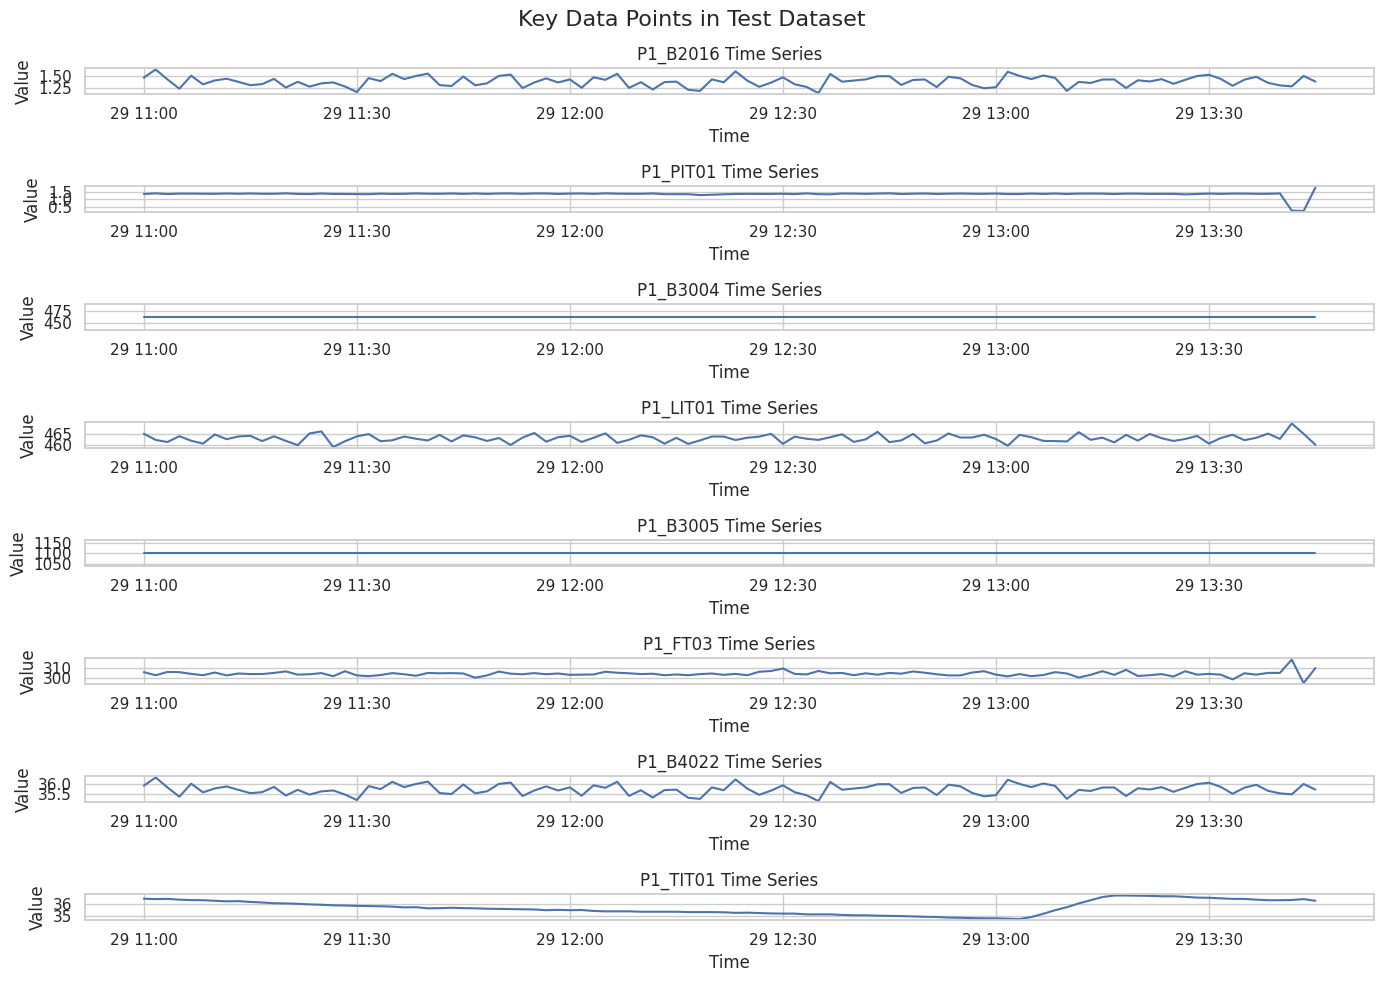

In [22]:
# Define key data points based on the HAI dataset technical details
key_points = [
    'P1_B2016',  # Pressure demand for thermal power output control
    'P1_PIT01',  # Heat-exchanger outlet pressure
    'P1_B3004',  # Water level setpoint (return water tank)
    'P1_LIT01',  # Water level of the return water tank
    'P1_B3005',  # Discharge flowrate setpoint (return water tank)
    'P1_FT03',   # Measured flowrate of the return water tank
    'P1_B4022',  # Temperature demand for thermal power output control
    'P1_TIT01'   # Heat-exchanger outlet temperature
]

# Check if these columns exist in the dataset
existing_key_points = [col for col in key_points if col in test1_sample.columns]
print(f"Available key points: {existing_key_points}")

# Plot time series for key data points
if existing_key_points:
    plot_time_series(test1_sample, existing_key_points, title="Key Data Points in Test Dataset")

### 2.5 Visualizing Attack Patterns

If attack labels are present, visualize the attack patterns along with key data points.

In [23]:
def plot_attack_periods(df, attack_col, data_cols, timestamp_col='time', max_periods=3, figsize=(14, 12)):
    """
    Plot data during attack periods.
    
    Args:
        df: DataFrame (pandas or cuDF)
        attack_col: Attack label column
        data_cols: List of data columns to plot
        timestamp_col: Name of the timestamp column
        max_periods: Maximum number of attack periods to plot
        figsize: Figure size
    """
    # Convert cuDF to pandas if needed
    if isinstance(df, cudf.DataFrame):
        plot_df = df.to_pandas()
    else:
        plot_df = df
    
    # Find attack periods
    attack_starts = []
    attack_ends = []
    in_attack = False
    
    for i, row in plot_df.iterrows():
        if row[attack_col] == 1 and not in_attack:
            attack_starts.append(i)
            in_attack = True
        elif row[attack_col] == 0 and in_attack:
            attack_ends.append(i-1)
            in_attack = False
    
    if in_attack:  # If dataset ends during an attack
        attack_ends.append(len(plot_df)-1)
    
    print(f"Found {len(attack_starts)} attack periods")
    
    # Visualize the first few attack periods
    num_attacks_to_show = min(max_periods, len(attack_starts))
    
    for i in range(num_attacks_to_show):
        start_idx = max(0, attack_starts[i] - 100)  # Include some pre-attack data
        end_idx = min(len(plot_df)-1, attack_ends[i] + 100)  # Include some post-attack data
        
        attack_df = plot_df.iloc[start_idx:end_idx].copy()
        
        # Plot key data points during this attack
        fig, axes = plt.subplots(len(data_cols)+1, 1, figsize=figsize)
        
        # Plot attack label
        axes[0].plot(attack_df[timestamp_col], attack_df[attack_col], 'r-')
        axes[0].set_title(f'Attack Period {i+1}')
        axes[0].set_ylabel('Attack')
        
        # Plot each data point
        for j, point in enumerate(data_cols):
            if point in attack_df.columns:
                axes[j+1].plot(attack_df[timestamp_col], attack_df[point])
                axes[j+1].set_title(f'{point} During Attack Period {i+1}')
                axes[j+1].set_ylabel('Value')
        
        plt.tight_layout()
        plt.show()

Found 1 attack periods


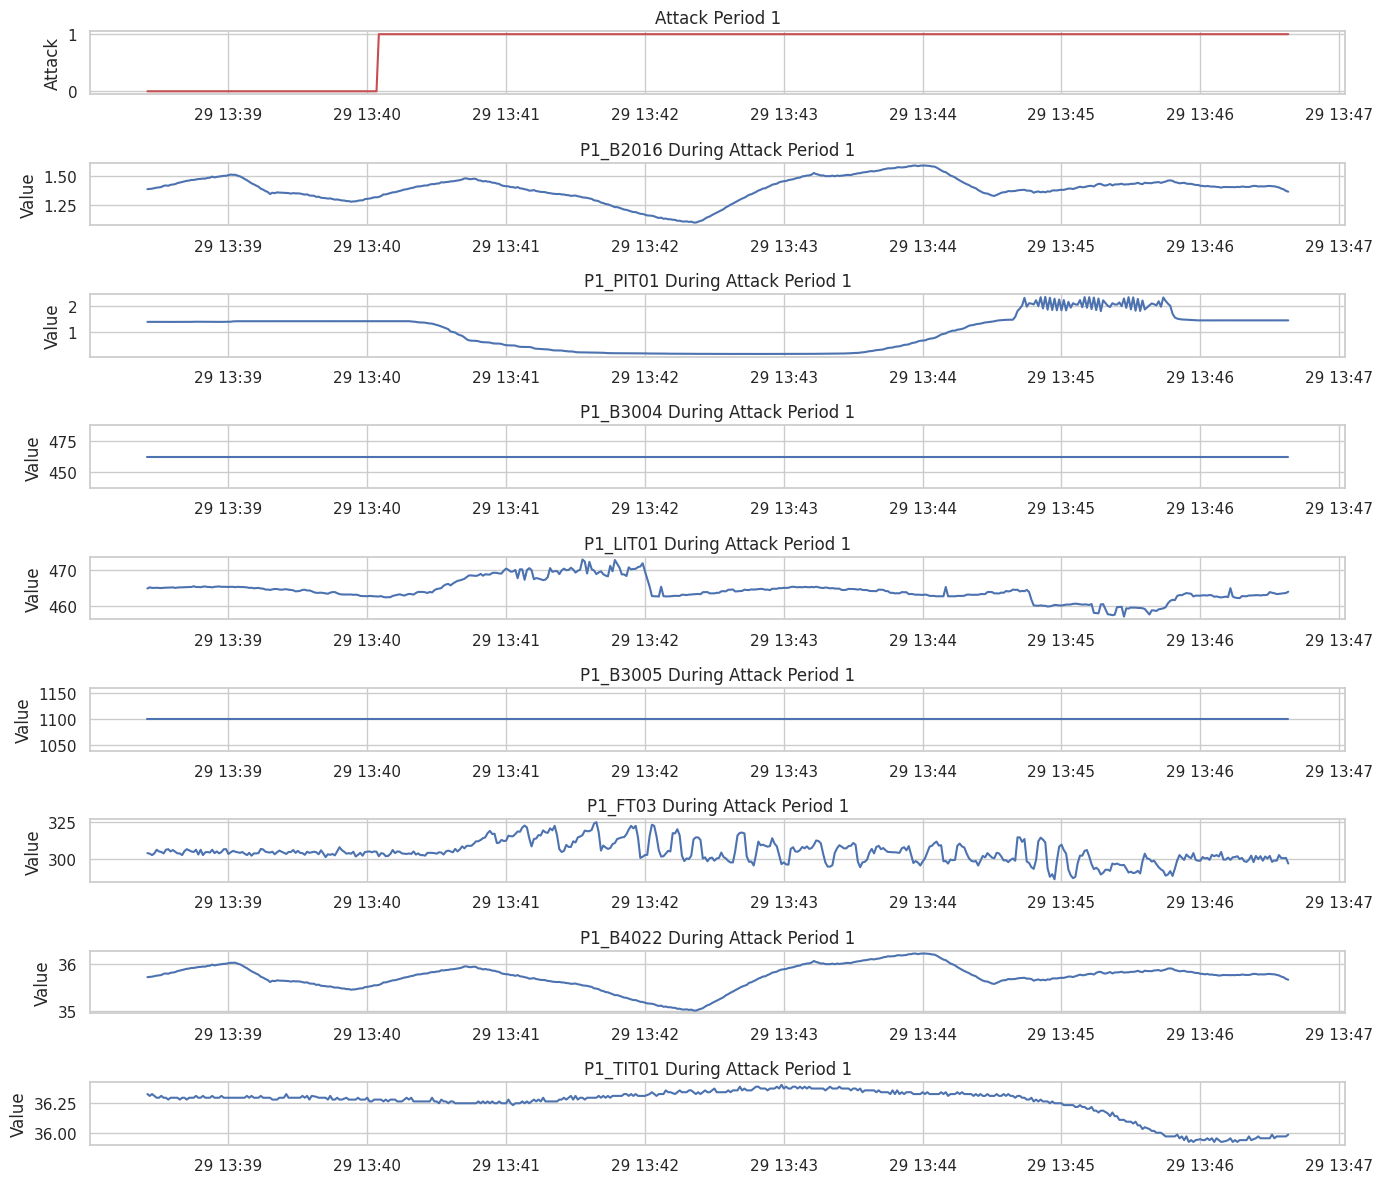

In [24]:
# Plot attack periods if attack labels are present
if attack_columns and existing_key_points:
    plot_attack_periods(test1_sample, attack_columns[0], existing_key_points)

## 3. Data Preprocessing Pipeline

Now let's create a comprehensive preprocessing pipeline for the HAI-20.07 dataset.

In [35]:
import glob
import os
import time
import pandas as pd
import dask.dataframe as dd
import joblib
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class HAIDataPreprocessor:
    """
    Preprocessing pipeline for HAI security dataset.
    """
    def __init__(self, dataset_version='hai-20.07', scaler_type='standard'):
        """
        Initialize the preprocessor.
        
        Args:
            dataset_version: Dataset version (e.g., 'hai-20.07')
            scaler_type: Type of scaler ('standard' or 'minmax')
        """
        self.dataset_version = dataset_version
        self.dataset_path = f'../hai-security-dataset/{dataset_version}/'
        self.scaler_type = scaler_type
        self.scaler = None
        self.timestamp_col = 'time' if dataset_version == 'hai-20.07' or dataset_version == 'hai-21.03' else 'timestamp'
        self.separator = ';' if dataset_version == 'hai-20.07' else ','
        self.feature_columns = None
        self.attack_columns = None
        
    def get_file_list(self):
        """
        Get list of training and test files.
        
        Returns:
            tuple: (train_files, test_files)
        """
        all_files = glob.glob(f'{self.dataset_path}*.csv')
        train_files = [f for f in all_files if 'train' in os.path.basename(f).lower()]
        test_files = [f for f in all_files if 'test' in os.path.basename(f).lower()]
        
        return train_files, test_files
    
    def load_file(self, file_path, sample_rows=None):
        """
        Load a CSV file efficiently.
        
        Args:
            file_path: Path to the CSV file
            sample_rows: Number of rows to sample (None for all rows)
            
        Returns:
            DataFrame: Loaded data
        """
        start_time = time.time()
        
        try:
            # First, use pandas to read a few rows to get column names and dtypes
            sample_df = pd.read_csv(file_path, sep=self.separator, nrows=5)
            
            # Create a dictionary of dtypes to optimize memory usage
            dtypes = {}
            for col in sample_df.columns:
                if col == self.timestamp_col:
                    dtypes[col] = 'object'  # Keep timestamp as object initially
                elif 'attack' in col.lower():
                    dtypes[col] = 'int8'  # Binary labels can be stored as int8
                elif sample_df[col].dtype == 'float64':
                    dtypes[col] = 'float64'  # Keep as float64 to avoid conversion issues
                elif sample_df[col].dtype == 'int64':
                    dtypes[col] = 'int32'  # Reduce precision to save memory
            
            # Use Dask to read the file in parallel chunks
            if sample_rows:
                # For sampling, use pandas directly
                df = pd.read_csv(file_path, sep=self.separator, dtype=dtypes, nrows=sample_rows)
            else:
                # For full file, use Dask
                dask_df = dd.read_csv(file_path, sep=self.separator, dtype=dtypes, blocksize="64MB")
                df = dask_df.compute()
        except ValueError as e:
            # If there's a dtype conversion error, try again without specifying dtypes
            print(f"Warning: Error with dtype conversion: {e}")
            print("Attempting to load without dtype specifications...")
            
            if sample_rows:
                df = pd.read_csv(file_path, sep=self.separator, nrows=sample_rows)
            else:
                dask_df = dd.read_csv(file_path, sep=self.separator, blocksize="64MB")
                df = dask_df.compute()
        
        # Convert timestamp
        if self.timestamp_col in df.columns:
            df[self.timestamp_col] = pd.to_datetime(df[self.timestamp_col])
        
        # Identify feature and attack columns
        if self.feature_columns is None:
            self.attack_columns = [col for col in df.columns if 'attack' in col.lower()]
            self.feature_columns = [col for col in df.columns 
                                   if col != self.timestamp_col and col not in self.attack_columns]
        
        print(f"Data loaded in {time.time() - start_time:.2f} seconds")
        return df
    
    def fit_scaler(self, train_files, sample_size=10000):
        """
        Fit a scaler on training data.
        
        Args:
            train_files: List of training file paths
            sample_size: Number of rows to sample from each file for fitting
            
        Returns:
            self: The fitted preprocessor
        """
        print(f"Fitting {self.scaler_type} scaler on training data...")
        
        # Initialize the appropriate scaler
        if self.scaler_type == 'standard':
            self.scaler = StandardScaler()
        elif self.scaler_type == 'minmax':
            self.scaler = MinMaxScaler()
        else:
            raise ValueError(f"Unknown scaler type: {self.scaler_type}")
        
        # Sample data from each training file
        all_samples = []
        for file in train_files:
            df = self.load_file(file, sample_rows=sample_size)
            all_samples.append(df[self.feature_columns])
        
        # Concatenate samples and fit the scaler
        combined_samples = pd.concat(all_samples)
        self.scaler.fit(combined_samples)
        
        print(f"Scaler fitted on {len(combined_samples)} samples")
        return self
    
    def transform_data(self, df):
        """
        Apply preprocessing transformations to a DataFrame.
        
        Args:
            df: Input DataFrame
            
        Returns:
            tuple: (X, y, timestamps) - Features, labels, and timestamps
        """
        # Extract features, labels, and timestamps
        X = df[self.feature_columns].copy()
        timestamps = df[self.timestamp_col].copy() if self.timestamp_col in df.columns else None
        
        # Extract labels if available
        y = None
        if self.attack_columns and all(col in df.columns for col in self.attack_columns):
            if len(self.attack_columns) == 1:
                y = df[self.attack_columns[0]].copy()
            else:
                y = df[self.attack_columns].copy()
        
        # Apply scaling if scaler is fitted
        if self.scaler is not None:
            X_scaled = self.scaler.transform(X)
            X = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
        
        return X, y, timestamps
    
    def save_preprocessor(self, output_dir='./models'):
        """
        Save the preprocessor to disk.
        
        Args:
            output_dir: Directory to save the preprocessor
            
        Returns:
            str: Path to the saved preprocessor
        """
        os.makedirs(output_dir, exist_ok=True)
        output_path = f"{output_dir}/hai_{self.dataset_version.replace('-', '_')}_{self.scaler_type}_preprocessor.joblib"
        
        # Create a dictionary with all necessary attributes
        preprocessor_dict = {
            'scaler': self.scaler,
            'feature_columns': self.feature_columns,
            'attack_columns': self.attack_columns,
            'timestamp_col': self.timestamp_col,
            'separator': self.separator,
            'dataset_version': self.dataset_version,
            'scaler_type': self.scaler_type
        }
        
        # Save to disk
        joblib.dump(preprocessor_dict, output_path)
        print(f"Preprocessor saved to {output_path}")
        
        return output_path
    
    @classmethod
    def load_preprocessor(cls, input_path):
        """
        Load a preprocessor from disk.
        
        Args:
            input_path: Path to the saved preprocessor
            
        Returns:
            HAIDataPreprocessor: Loaded preprocessor
        """
        # Load from disk
        preprocessor_dict = joblib.load(input_path)
        
        # Create a new instance
        preprocessor = cls(dataset_version=preprocessor_dict['dataset_version'],
                          scaler_type=preprocessor_dict['scaler_type'])
        
        # Restore attributes
        preprocessor.scaler = preprocessor_dict['scaler']
        preprocessor.feature_columns = preprocessor_dict['feature_columns']
        preprocessor.attack_columns = preprocessor_dict['attack_columns']
        preprocessor.timestamp_col = preprocessor_dict['timestamp_col']
        preprocessor.separator = preprocessor_dict['separator']
        
        print(f"Preprocessor loaded from {input_path}")
        return preprocessor

### 3.1 Fit Preprocessor on HAI-20.07 Dataset

In [36]:
# Initialize preprocessor for HAI-20.07
preprocessor = HAIDataPreprocessor(dataset_version='hai-20.07', scaler_type='standard')

# Get training and test files
train_files, test_files = preprocessor.get_file_list()
print(f"Training files: {[os.path.basename(f) for f in train_files]}")
print(f"Test files: {[os.path.basename(f) for f in test_files]}")

# Fit scaler on training data
preprocessor.fit_scaler(train_files)

# Save preprocessor
preprocessor.save_preprocessor()

Training files: ['train2.csv', 'train1.csv']
Test files: ['test2.csv', 'test1.csv']
Fitting standard scaler on training data...
Attempting to load without dtype specifications...
Data loaded in 0.14 seconds
Attempting to load without dtype specifications...
Data loaded in 0.09 seconds
Scaler fitted on 20000 samples
Preprocessor saved to ./models/hai_hai_20.07_standard_preprocessor.joblib


'./models/hai_hai_20.07_standard_preprocessor.joblib'

### 3.2 Process and Save Training Data

In [37]:
def process_and_save_data(preprocessor, file_paths, output_dir='./processed_data', chunk_size=100000):
    """
    Process and save data in chunks.
    
    Args:
        preprocessor: HAIDataPreprocessor instance
        file_paths: List of file paths to process
        output_dir: Directory to save processed data
        chunk_size: Size of each chunk
        
    Returns:
        list: Paths to saved files
    """
    os.makedirs(output_dir, exist_ok=True)
    saved_files = []
    
    for file_path in file_paths:
        file_name = os.path.basename(file_path)
        print(f"Processing {file_name}...")
        
        # Process in chunks
        chunk_reader = pd.read_csv(file_path, sep=preprocessor.separator, chunksize=chunk_size)
        
        for i, chunk in enumerate(chunk_reader):
            # Convert timestamp
            if preprocessor.timestamp_col in chunk.columns:
                chunk[preprocessor.timestamp_col] = pd.to_datetime(chunk[preprocessor.timestamp_col])
            
            # Transform data
            X, y, timestamps = preprocessor.transform_data(chunk)
            
            # Create output DataFrame
            output_df = X.copy()
            if timestamps is not None:
                output_df[preprocessor.timestamp_col] = timestamps
            if y is not None:
                if isinstance(y, pd.Series):
                    output_df['attack'] = y
                else:  # DataFrame
                    for col in y.columns:
                        output_df[col] = y[col]
            
            # Save chunk
            output_path = f"{output_dir}/{file_name.replace('.csv', f'_chunk{i}.npz')}"
            np.savez_compressed(output_path, 
                               data=output_df.to_numpy(), 
                               columns=output_df.columns.tolist())
            
            saved_files.append(output_path)
            print(f"  Saved chunk {i} to {output_path}")
    
    return saved_files

In [38]:
# Process and save training data
train_output_dir = './processed_data/hai-20.07/train'
train_saved_files = process_and_save_data(preprocessor, train_files, output_dir=train_output_dir)

# Process and save test data
test_output_dir = './processed_data/hai-20.07/test'
test_saved_files = process_and_save_data(preprocessor, test_files, output_dir=test_output_dir)

Processing train2.csv...
  Saved chunk 0 to ./processed_data/hai-20.07/train/train2_chunk0.npz
  Saved chunk 1 to ./processed_data/hai-20.07/train/train2_chunk1.npz
  Saved chunk 2 to ./processed_data/hai-20.07/train/train2_chunk2.npz
Processing train1.csv...
  Saved chunk 0 to ./processed_data/hai-20.07/train/train1_chunk0.npz
  Saved chunk 1 to ./processed_data/hai-20.07/train/train1_chunk1.npz
  Saved chunk 2 to ./processed_data/hai-20.07/train/train1_chunk2.npz
  Saved chunk 3 to ./processed_data/hai-20.07/train/train1_chunk3.npz
Processing test2.csv...
  Saved chunk 0 to ./processed_data/hai-20.07/test/test2_chunk0.npz
  Saved chunk 1 to ./processed_data/hai-20.07/test/test2_chunk1.npz
Processing test1.csv...
  Saved chunk 0 to ./processed_data/hai-20.07/test/test1_chunk0.npz
  Saved chunk 1 to ./processed_data/hai-20.07/test/test1_chunk1.npz
  Saved chunk 2 to ./processed_data/hai-20.07/test/test1_chunk2.npz


### 3.3 Load and Verify Processed Data

In [41]:
def load_processed_data(file_path):
    """
    Load processed data from NPZ file.
    
    Args:
        file_path: Path to the NPZ file
        
    Returns:
        DataFrame: Loaded data
    """
    # Load NPZ file
    npz_data = np.load(file_path, allow_pickle=True)
    
    # Convert to DataFrame
    df = pd.DataFrame(npz_data['data'], columns=npz_data['columns'])
    
    return df

In [42]:
# Load and verify a processed file
if train_saved_files:
    sample_file = train_saved_files[0]
    print(f"Loading {sample_file}...")
    
    loaded_df = load_processed_data(sample_file)
    print(f"Loaded data shape: {loaded_df.shape}")
    print("\nFirst 5 rows:")
    display(loaded_df.head())

Loading ./processed_data/hai-20.07/train/train2_chunk0.npz...
Loaded data shape: (100000, 64)

First 5 rows:


,P1_B2004,P1_B2016,P1_B3004,P1_B3005,P1_B4002,P1_B4005,P1_B400B,P1_B4022,P1_FCV01D,P1_FCV01Z,...,P4_ST_LD,P4_ST_PO,P4_ST_PS,P4_ST_PT01,P4_ST_TT01,time,attack,attack_P1,attack_P2,attack_P3
0,0.615849,0.79097,1.296907,-1.32927,0.0,-0.835411,-0.998528,-0.070242,-0.582097,-0.599257,...,-0.092789,-0.055498,-1.333305,1.125134,0.268575,2019-11-01 20:00:00,0,0,0,0
1,0.615849,0.759732,1.296907,-1.32927,0.0,-0.834774,-0.997651,-0.120238,-0.578439,-0.599257,...,-0.142367,-0.039328,-1.333305,1.125134,0.220541,2019-11-01 20:00:01,0,0,0,0
2,0.615849,0.758195,1.296907,-1.32927,0.0,-0.83458,-0.995897,-0.122525,-0.577762,-0.599257,...,-0.141844,-0.080914,-1.333305,1.125134,0.172506,2019-11-01 20:00:02,0,0,0,0
3,0.615849,0.766901,1.296907,-1.32927,0.0,-0.834289,-0.994142,-0.108801,-0.575898,-0.599257,...,-0.163242,-0.09131,-1.333305,1.125134,0.268575,2019-11-01 20:00:03,0,0,0,0
4,0.615849,0.75922,1.296907,-1.32927,0.0,-0.833408,-0.998528,-0.121545,-0.576944,-0.599257,...,-0.176808,-0.132318,-1.333305,1.125134,0.172506,2019-11-01 20:00:04,0,0,0,0


## 4. Preprocessing for Other Dataset Versions

The same preprocessing pipeline can be applied to other HAI dataset versions with minor adjustments.

In [43]:
def preprocess_dataset_version(version, scaler_type='standard'):
    """
    Preprocess a specific HAI dataset version.
    
    Args:
        version: Dataset version (e.g., 'hai-21.03')
        scaler_type: Type of scaler ('standard' or 'minmax')
        
    Returns:
        tuple: (preprocessor, train_saved_files, test_saved_files)
    """
    print(f"Preprocessing {version} dataset...")
    
    # Initialize preprocessor
    preprocessor = HAIDataPreprocessor(dataset_version=version, scaler_type=scaler_type)
    
    # Get training and test files
    train_files, test_files = preprocessor.get_file_list()
    print(f"Training files: {[os.path.basename(f) for f in train_files]}")
    print(f"Test files: {[os.path.basename(f) for f in test_files]}")
    
    # Fit scaler on training data
    preprocessor.fit_scaler(train_files)
    
    # Save preprocessor
    preprocessor.save_preprocessor()
    
    # Process and save training data
    train_output_dir = f'./processed_data/{version}/train'
    train_saved_files = process_and_save_data(preprocessor, train_files, output_dir=train_output_dir)
    
    # Process and save test data
    test_output_dir = f'./processed_data/{version}/test'
    test_saved_files = process_and_save_data(preprocessor, test_files, output_dir=test_output_dir)
    
    return preprocessor, train_saved_files, test_saved_files

In [45]:
# Example: Preprocess HAI-21.03 dataset
# Uncomment to run
preprocessor_21_03, train_files_21_03, test_files_21_03 = preprocess_dataset_version('hai-21.03')

Preprocessing hai-21.03 dataset...
Training files: ['train3.csv', 'train2.csv', 'train1.csv']
Test files: ['test5.csv', 'test4.csv', 'test3.csv', 'test2.csv', 'test1.csv']
Fitting standard scaler on training data...
Attempting to load without dtype specifications...
Data loaded in 0.22 seconds
Attempting to load without dtype specifications...
Data loaded in 0.13 seconds
Attempting to load without dtype specifications...
Data loaded in 0.11 seconds
Scaler fitted on 30000 samples
Preprocessor saved to ./models/hai_hai_21.03_standard_preprocessor.joblib
Processing train3.csv...
  Saved chunk 0 to ./processed_data/hai-21.03/train/train3_chunk0.npz
  Saved chunk 1 to ./processed_data/hai-21.03/train/train3_chunk1.npz
  Saved chunk 2 to ./processed_data/hai-21.03/train/train3_chunk2.npz
  Saved chunk 3 to ./processed_data/hai-21.03/train/train3_chunk3.npz
  Saved chunk 4 to ./processed_data/hai-21.03/train/train3_chunk4.npz
Processing train2.csv...
  Saved chunk 0 to ./processed_data/hai-21

## 5. Conclusion

In this notebook, we've implemented a comprehensive preprocessing pipeline for the HAI security dataset, focusing on:

1. Efficient data loading using Dask and cuDF for GPU acceleration
2. Data exploration and visualization
3. Feature scaling and normalization
4. Processing and saving data in a format optimized for model training

The preprocessed data and fitted preprocessors are saved and ready to be used for training anomaly detection models in separate notebooks.